In [3]:
# IMPORT VARIABLES, LIBRARIES AND FUNCTIONS
%matplotlib inline
import timeit

from analysis_funk import * # Stored functions and variables to plot the map of Paris
from mvp_funk import * 

print(data.shape, paris_attractions.shape)

(36858, 29) (449, 3)


# Initial Data Cleaning Approach and Exploratory Findings

From the 91 columns, I filtered out 30 columns containing paragraphs of descriptions and reviews and variables that were unnecessary (correlated) or irrelevant to the analysis. On the second filter, columns with a high volume of missing or incorrect values got removed leaving the dataset with 49 pertinent columns. I then grouped them in 5 categories: Host qualities, Listing specs, Location data and Review scores.  

#### Cleaning listings coordinates

I found 3 types of innacuracies regarding the zipcodes, city name and coordinates. The zipcodes and the cities were either mispelled or unrelated. After standardizing the cities and zipcodes I grouped all the listings by zipcode and took the common city name to be the official name for the whole zipcode. The following figure shows the listings classified by color according to their zipcode.  

![**Figure PRE original listings per zipcode**](../images/Centroids_and_original_listings.png)

An LOF process showed 208 listings with either an incorrect zipcode or coordinates. I had to assume that the coordinates were correct so I proceeded to adjust the zipcode according to its nearest zipcode center of mass as shown below: 

![**Figure PRE original listings per zipcode**](../images/Centroids_and_final_listings.png)

---
## Getting the Occupancy rate:

Airbnb guests may leave a review after their stay, and these can be used as an indicator of airbnb activity (although not all guests leave a review, so the actual booking activity would be much higher). The occupancy rate according to Airbnb would be: 

>***Occupancy_rate = MAX(average_length_of_stay, minimum_nights)x(number_of_reviews)***

An average length of stay is configured for each city, and this, multiplied by the estimated bookings for each listing over a period gives the occupancy rate. For Paris, the average_length_of_stay is set to 3 nights/booking 

**Things to consider:**

- The listing's ancienty. A listing that just started in Airbnb is less likely to have as much reviews as an older listing. There's at least 7000 listings whose first review dates from this year! 

*To counteract the ancienty vs new listings bias, I will normalize the occupancy rate per month and assign its average rate as such. The dataset provides a column called reviews per month.*

- The availability.  A listing with a high availability is susceptible to get more reviews and thus increasing its occupancy rate. An Airbnb host can setup a calendar for their listing so that it is only available for a few days or weeks a year. Other listings are available all year round (except for when it is already booked). This poses a problem as the availability cannot be considered an accurate measure since it can either show the number of days the listing is supposed to be available but it can also show the remaining days a listing hasn't yet been booked thus lowering its availability.

***SCENARIO 1: ***The availability column means the number of days the listing is available per year, set by the host.

If the availability column is considered, then those listings with 0 days available will have to be removed or their value set to a non-zero one. There are 13045 listings that have no availability available, aside from that, the average availability is 145 days. 

Airbnb divides these listings in two categories: High availability for those listings with more than 120 days available and low availability for the rest. In this analysis I will not categorize the listings in these two broad groups but simply assign a weight proportional to its own availability. 

Then the occupancy rate has to be capped by:

> *** occupancy_rate <= min(1, (min_nights x booking_per_year)/days_available)***

.. since the term *(min_nights x booking_per_year)/days_available* can be higher than 1 and therefore not fair for listings with low availability. 

In this scenario the occupancy rate distribution is boxplotted below: 

#### *Choosing scenario 2 since the availability on scenario 1 doesnt have much of a discrimination power (since the median is the same as its 75% and 100% percentiles)*

In [154]:
from bisect import bisect
orate_dico = {0:5, 0.2:10, 0.4:15, 0.8:20, 0.9:25, 0.925:30, 0.95:35, 0.975:40, 1:75}
orate = [0, 0.2, 0.4, 0.8, 0.9, 0.925, 0.95, 0.975, 1]


def get_interval_on_rate(o_rate):
    main_intrvl = orate[bisect(orate, o_rate)-1]
    return orate_dico[main_intrvl]

o_rate = data.loc[(data.zipcode<76000)&(data.occupancy_rate<1),['longitude','latitude','zipcode','occupancy_rate']]
#o_rate ['interval_o_rate'] = o_rate.occupancy_rate.apply(get_interval_on_rate)

In this scenario the rate averages 0.752 and the median is 1. 

***SCENARIO 2*** The availability column refers to the days of the year that remain available and therefore there is no value in this variable as it doesnt describe the availability. The occupancy rate will be the one defined by Airbnb in the first case: 

> *Average occupancy_rate per year = min_nights x bookings per year = 12 x min_nights x reviews_per_month*

where basically says that the higher the average of bookings (reviews) per year, the higher the rate and thus the minimum nights can be removed as it is just a constant. The distribution yielded: 

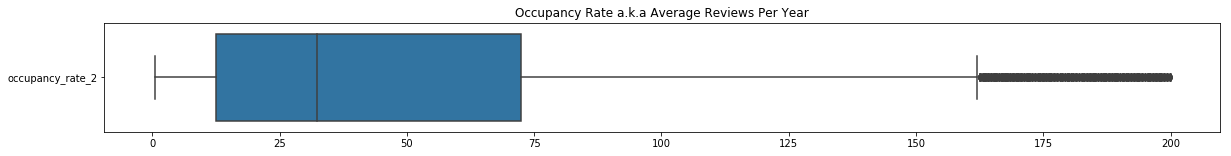

In [50]:
data['occupancy_rate_2'] = [rpm*12*4.5 for rpm in data.reviews_per_month]
fig = plt.figure(figsize = (20,2))
sns.boxplot(data=data.loc[data.occupancy_rate_2<200,['occupancy_rate_2']], orient="h")
plt.title('Occupancy Rate a.k.a Average Reviews Per Year')
plt.show()

In [51]:
fig.savefig('../images/PROJ_Occupancy_rate_scenario_2.png', bbox_inches='tight')

---

## How can a grading system be implemented using the following parameters: 
- HOST_SUPERHOST: will have values 100 or 0
- ROOM_TYPE: will be mapped with normalized values as such: 
'Entire home/apt' 100 pts, 'Private room' 50 pts and 'Shared room' 0 pts
- BED_TYPE: will be mapped with normalized values as such: 
Real bed: 100 pts, Pull-out Sofa, Couch, Futon and Airbed: 50pts
- BATHROOMS: will be normalized by 100 as the more bathrooms the fancier the listing is. 
- AMENITIES: has 100 for any listing with 100% of the essential amenities.   
- REVIEW SCORES: They are already normalized scores. 

In [2]:
print('Quantifying listings..')

# Set host_is_superhost values from 100 to 0
data.host_is_superhost = data.host_is_superhost.apply(lambda x: x*100)
# Map room type
rt_map = {'Entire home/apt': 100, 'Private room': 50, 'Shared room':0}
data.room_type = data.room_type.map(rt_map)
# Map bed type
bt_map = {'Real Bed': 100, 'Pull-out Sofa': 50, 'Airbed':50, 'Couch':0, 'Futon':0}
data.bed_type = data.bed_type.map(bt_map)
# Normalize bathrooms
data.bathrooms = data.bathrooms.apply(lambda x: (x-data.bathrooms.min())/(data.bathrooms.max()-data.bathrooms.min()))
# Normalize review scored by 100
data.review_scores_accuracy = data.review_scores_accuracy.apply(lambda x: x*10)
data.review_scores_cleanliness = data.review_scores_cleanliness.apply(lambda x: x*10)
data.review_scores_checkin = data.review_scores_checkin.apply(lambda x: x*10)
data.review_scores_communication = data.review_scores_communication.apply(lambda x: x*10)
data.review_scores_value = data.review_scores_value.apply(lambda x: x*10)

Quantifying listings..


In [5]:
l_col = ['host_is_superhost','room_type','bed_type','bathrooms','amty_per','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_value']
data[l_col].head()

,host_is_superhost,room_type,bed_type,bathrooms,amty_per,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value
listing_id,,,,,,,,,,
17994,100,100,100,0.03,56.25,100.0,80.0,90.0,100.0,90.0
10607664,0,100,100,0.02,68.75,100.0,100.0,100.0,100.0,90.0
3304443,0,100,100,0.02,56.25,100.0,100.0,100.0,100.0,100.0
11155986,100,100,100,0.04,87.50,100.0,100.0,100.0,100.0,100.0
3393864,0,100,100,0.02,87.50,90.0,90.0,90.0,90.0,90.0


In [10]:
params_listings = data.loc[:,l_col]
params_listings['best_listings'] = params_listings.mean(axis=1)

best_listings = pd.merge(data[['zipcode','latitude','longitude']], params_listings[['best_listings']], right_index=True, left_index=True)
best_listings.sort_values('best_listings',ascending=False).head()

,zipcode,latitude,longitude,best_listings
listing_id,,,,
18385589,75002,48.871,2.339,90.008
11815308,75016,48.865,2.288,90.006
5217824,75001,48.866,2.326,90.006
11522022,75017,48.883,2.297,90.006
195927,75018,48.882,2.341,90.005


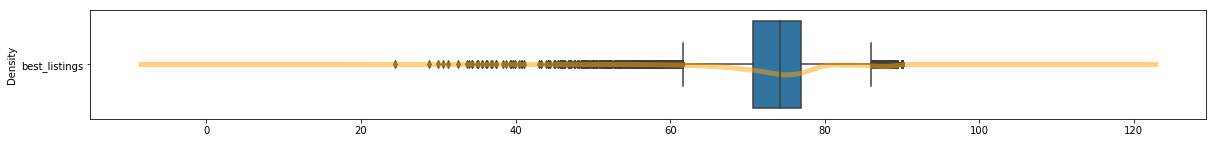

In [8]:
fig = plt.figure(figsize = (20,2))
sns.boxplot(data=best_listings.loc[:,['best_listings']], orient="h")
best_listings.best_listings.plot(kind='kde',c='orange', linewidth=5, alpha=0.5)
plt.show()

---
# LOCATION: 
## What is the best district in terms of location? 
- What is the proportion of listings per district?

In [49]:
mys = data.loc[:,['zipcode','latitude','longitude','price','review_scores_location']].sample(frac=1)
mys.shape

(36858, 5)

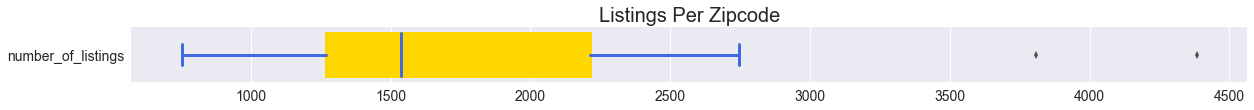

In [2]:


listings_per_zip = mys[['latitude','zipcode']].groupby('zipcode').count().rename(columns={'latitude':'number_of_listings'})
fig = plt.figure(figsize = (20,1))
sns.boxplot(data=listings_per_zip,
            orient="h", boxprops=dict(color='gold'), 
            capprops=dict(color='royalblue'), whiskerprops=dict(color='royalblue'),
            flierprops=dict(color='firebrick', markeredgecolor='firebrick'), 
            medianprops=dict(color='royalblue'))

plt.title('Listings Per Zipcode')
plt.show()

*We'll keep in mind that there are 2 districts that are overpopulated with listings: the 11th and 18th district. Whereas the 1st and the 8 have less than a thousand listings. This measure doesnt consider the density though, just the total number of listings.*

- What is the average PRICE of listings per district? Are there districts that can be considerably high or low? Consider the space
- can we see which arrondissement is most expensive in function of the musings price? Which arrondissement has the most pricey listings? Does it correlate with the number of amenities? Or space? 

In [3]:
data.price.describe()

count    36858.000
mean        98.628
std        120.335
min          8.000
25%         55.000
50%         75.000
75%        110.000
max       9379.000
Name: price, dtype: float64

When it comes to price, the listings can be divided in 2 ranges: 
    - 0 to 110$
    - 110$ to end

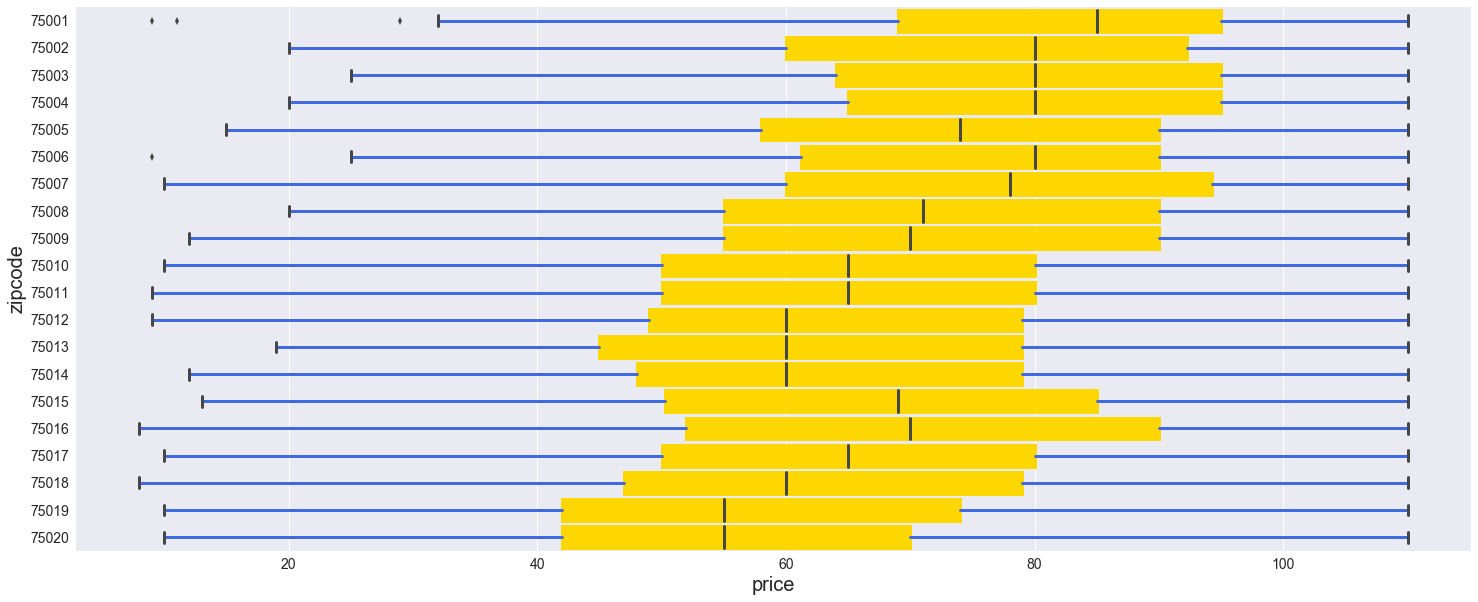

In [4]:
price_per_zip = data.loc[data.price<=110, ['zipcode','price']]
fig = plt.figure(figsize = (25,10))
sns.boxplot(x='price',y='zipcode' ,data=price_per_zip, orient='h',
            boxprops=dict(color='gold'),
            whiskerprops=dict(color='royalblue'))
plt.show()

For 75% of the listings, the median ranges from 50 to 90 dls and according to the plot above, the median is higher for districts closer to the center of the city (75001-75008) and slowly decreases for districts farther away from the center with the exception of the 16th district which is well-known to be one of the most expensive for . 

For the more expensive listings: 

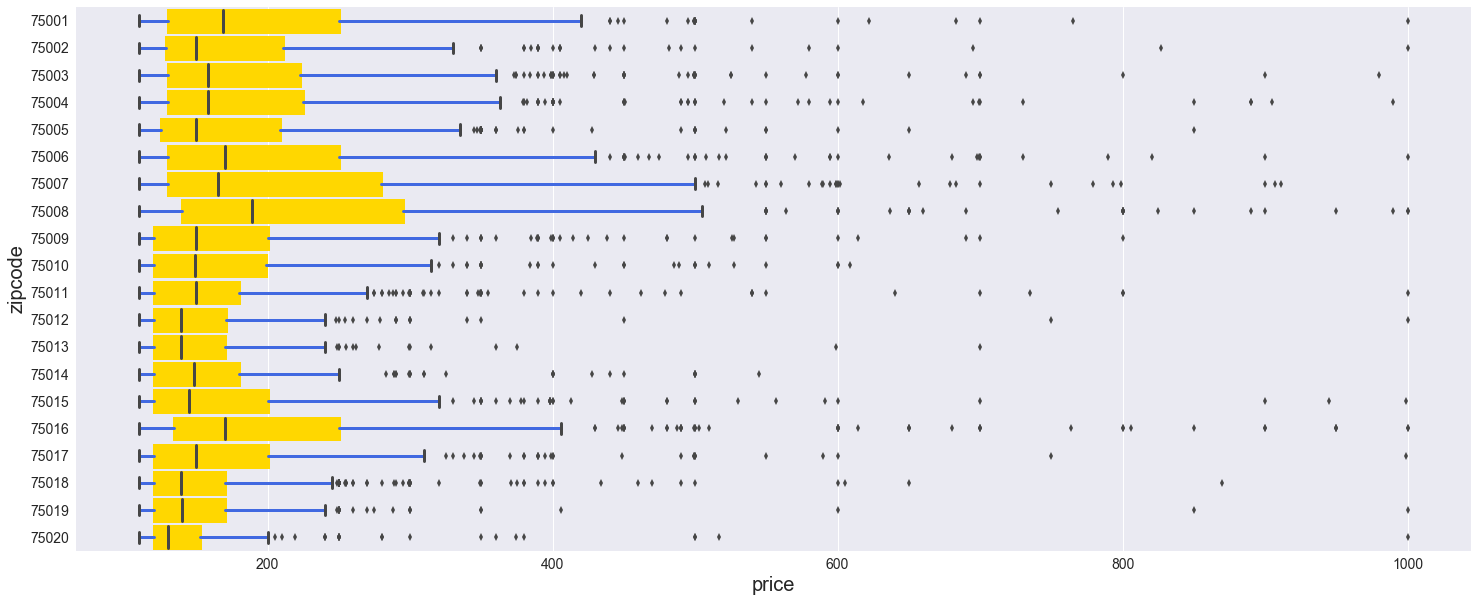

In [22]:
price_per_zip = data.loc[(data.price>=110)&(data.price<=1000), ['zipcode','price','latitude','longitude']]
fig = plt.figure(figsize = (25,10))
sns.boxplot(x='price',y='zipcode' ,data=price_per_zip, orient='h',
            boxprops=dict(color='gold'),
            whiskerprops=dict(color='royalblue'))
plt.show()

The 16th surpassed the 1st and the 6th, sitting just below the 8th

In [30]:
price_per_zip = data.loc[:,['zipcode','price','latitude','longitude']]

In [35]:
# Normalize price
def cap_price(x):
    if x.price>500:
        return 1
    else: 
        return (x.price-8)/(500-8)
price_per_zip['real_price'] = price_per_zip.apply(lambda x: cap_price(x), axis=1)

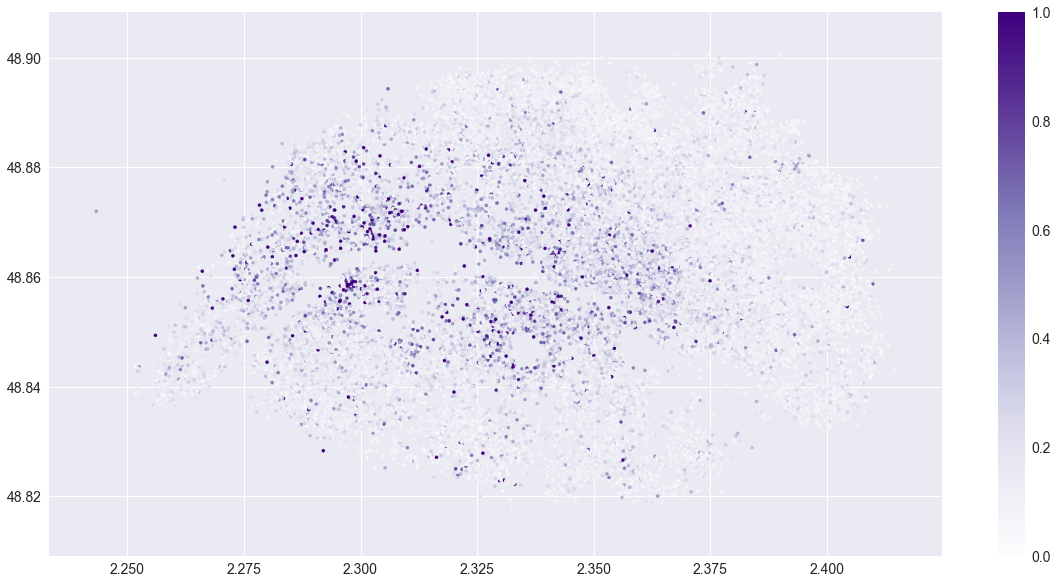

In [47]:
fig = plt.figure(figsize=(20,10))
plt.scatter(price_per_zip.longitude.values, price_per_zip.latitude.values, s=10, c=price_per_zip.real_price.values, cmap='Purples' ,zorder=2, alpha=1)
plt.colorbar()
plt.show()

---
# KNN attractions for every listing. 

In [50]:
def get_distEuclid_from_attractions(x):
    d = np.sqrt((paris_attractions.longitude - x.longitude)**2 + (paris_attractions.latitude - x.latitude)**2)
    #return [d.sort_values()] # as a list of a serie
    return [d.values] # As a list of an array

***Takes 1 min***

In [51]:
# Get euclidean distance
mys['attraction'] = mys.apply(lambda x: get_distEuclid_from_attractions(x), axis=1)

In [52]:
# Transform list of distances into dataframe along with its listing id. 
all_dist = []
ndist = []
number_attr = paris_attractions.shape[0]

for idx, content in mys.iterrows():
    all_dist+=[list(np.repeat(idx,number_attr)),list(content.attraction[0][:number_attr])]

idx = []
for i in all_dist[0:-1:2]:
    idx+=i
for d in all_dist[1::2]:
    ndist+=d
    
nDist = pd.DataFrame({'listing' : idx, 'distance': ndist})

In [53]:
mys.drop('attraction', axis=1, inplace=True)

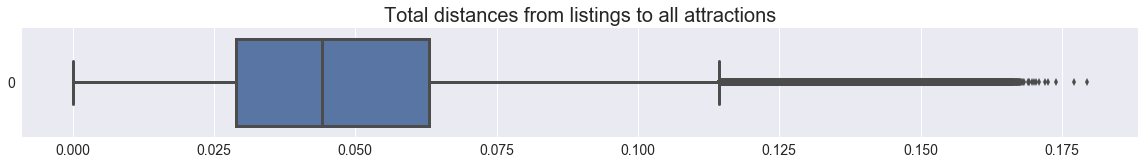

In [54]:
fig = plt.figure(figsize = (20,2))
sns.boxplot(data=nDist.distance, orient="h")
plt.title('Total distances from listings to all attractions')
plt.show()

---

***To grade the listings in terms of their proximity with the touristy places a listing having the longest distance to its closest attraction (top_dist) will have the minimum value. Then the value of a listing will increase as the number of attractions found within the radius set by top_dist. The listing having most of the attractions within that distance will therefore have the maximum score.*** 

***Takes 3 min***

In [10]:

print('Calculating location score ..')
# Get all listings' distance to their closest neighbor
closest_neighbor_distances = nDist.groupby('listing').min()
# Take the longest distance from that
top_dist = closest_neighbor_distances.loc[closest_neighbor_distances.idxmax().values[0]].distance
# Get all the listings with their distances below the top_dist
location_listings = nDist.loc[nDist.distance<=top_dist].groupby('listing').count().rename(columns={'distance':'num_of_attractions'}).sort_values('num_of_attractions', ascending=False)
# Grade the listings with a normalized metric reflecting the number of attractions. 
mys['location_score'] = location_listings.num_of_attractions.apply(lambda x: (x-min(location_listings.num_of_attractions))/(max(location_listings.num_of_attractions)-min(location_listings.num_of_attractions)))

print('Location score retrieved!')


Calculating location score ..
Location score retrieved!


In [13]:
mys.sort_values('location_score', ascending=False).head()

,zipcode,latitude,longitude,attraction,location_score
listing_id,,,,,
15612175,75005,48.851,2.346,"[[0.00749218511113, 0.0118854231928, 0.0110408...",1.000
13430660,75005,48.851,2.346,"[[0.00747669421365, 0.0118890595505, 0.0110580...",1.000
18234881,75005,48.852,2.346,"[[0.00691460048881, 0.0120474016173, 0.0116841...",0.991
1715064,75005,48.852,2.346,"[[0.00701876757253, 0.0120039078816, 0.0115739...",0.991
20245564,75005,48.851,2.346,"[[0.00760161069353, 0.0116401009834, 0.0110370...",0.991


In [14]:
# Build dataframe with the number of listings having n number of attractions within the radius of top_dist
num_atrr_vs_num_list = location_listings.reset_index().groupby('num_of_attractions').count()      

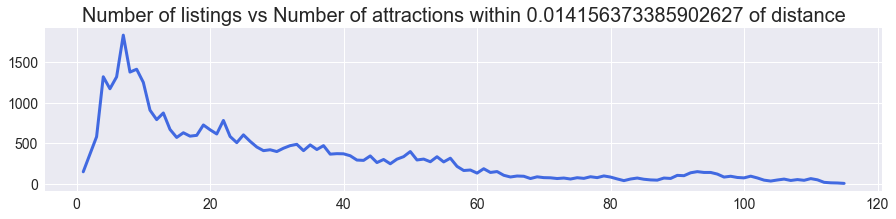

In [15]:
# Plot Number of listings vs Number of attractions
fig=plt.figure(figsize=(15,3))
plt.plot(num_atrr_vs_num_list.index, num_atrr_vs_num_list['listing'], marker='', color='royalblue', linewidth=3, alpha=1, label='Number of listings')
plt.title('Number of listings vs Number of attractions within {0} of distance'.format(top_dist))
plt.show()

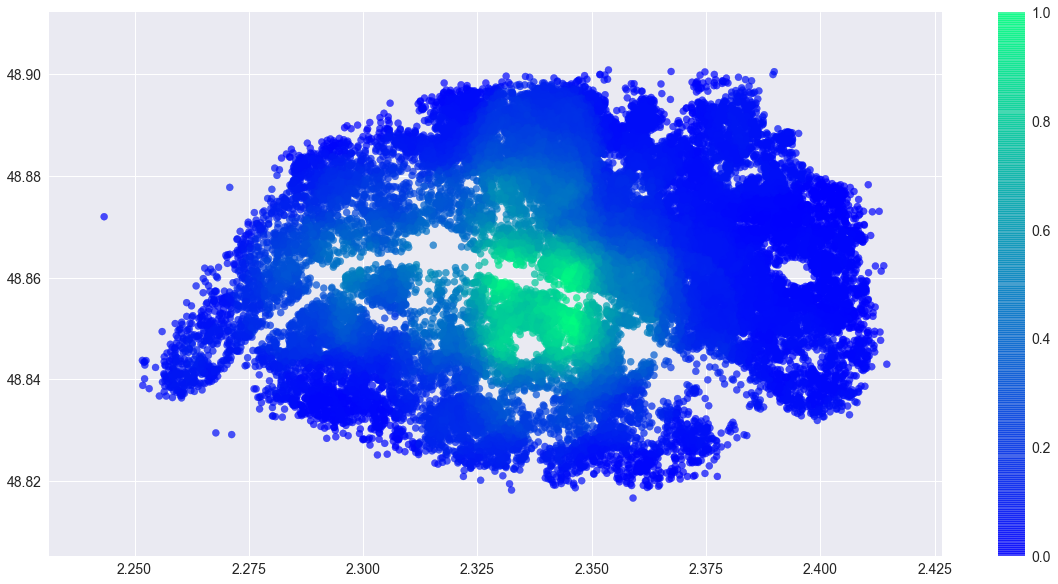

In [18]:
fig = plt.figure(figsize=(20,10))
plt.scatter(mys.longitude.values, mys.latitude.values, s=50, c=mys.location_score.values, cmap='winter' ,zorder=2, alpha=0.7)
plt.colorbar()
plt.show()

Merge with location score

In [48]:
data.head()

,host_id,host_since,host_response_time,host_is_superhost,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,zipcode,amenities,amty_per,number_of_reviews,reviews_per_month
listing_id,,,,,,,,,,,,,,,,,,,,,
5396,7903,2009-02-14,within an hour,False,48.851,2.359,Apartment,Entire home/apt,2,1.0,...,9.0,10.0,10.0,10.0,9.0,75004,"['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche...",75.00,133,1.750
7397,2626,2008-08-30,within an hour,True,48.858,2.353,Apartment,Entire home/apt,4,1.0,...,9.0,10.0,10.0,10.0,9.0,75004,"['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche...",87.50,218,2.691
10010,33995,2009-08-26,within an hour,True,48.863,2.375,Apartment,Entire home/apt,5,1.0,...,10.0,10.0,10.0,10.0,10.0,75011,"['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche...",81.25,125,2.717
10270,33995,2009-08-26,within an hour,True,48.867,2.375,Apartment,Entire home/apt,4,1.0,...,10.0,10.0,10.0,10.0,10.0,75011,"['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche...",75.00,128,3.368
10588,37107,2009-09-08,within a few hours,False,48.889,2.345,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,9.0,10.0,75018,"['TV', 'Cable TV', 'Internet', 'Wifi', 'Kitche...",43.75,16,1.143


___

# Further Research and Analysis

Analyze more the occupancy rate. Listings (old and new) which have availability only in the high season vs those available in both seasons. 

There is room to implement association rules in variables such as amenities and host_verifications. 
What are rare amenities and which ones are the most common? are most rare amenities considered luxurious? which of them can be considered as such? Which categories can be considered luxurious?

Im curious what do listings that have 0 amenities, have to offer... do they have a non-null value for the accomodates and guest_included values?



NLP: What is the evolution of good reviews for a particular listing? Is there an associative rule? 

Is Paris visited mostly by romantic couples or party animals?
    - Check the house_rules

Time series?? 

Sense of space? How spatious are the listings? Can we define it using some of these columns? Like # of beds and bathrooms, amenities etc... 

Fairness of the judgement. There is some inequality here as the listings ancienty is not very well considered here. 

- Histogramme egalization on the listings distances to attractions since there were a lot of listings with low scores. 

# Appendix
1. This is the format of the html code scraped to get the coordinates of some of the tourist attractions in Paris. 

https://latitude.to/map/fr/france/cities/paris
<ul>
<li>
    <article>
    <h3 class="title">
        <a href="/map/fr/france/cities/paris/articles/6/eiffel-tower" title="GPS Coordinates of Eiffel Tower">Eiffel Tower</a>
    </h3>
    <p>The 
        <b>Eiffel Tower</b> (French: <span lang="fr" xml:lang="fr">
        <b>La tour Eiffel</b></span>, 
        <span title="Representation in the International Phonetic Alphabet (IPA)">[tuʁ ɛfɛl]</span>) is an iron lattice tower located on the Champ de Mars in Paris, France. It was named after the engineer Alexandre Gustave Eiffel, whose company designed and built the tower. Erected in 1889 as th…
    </p>
    <div class="act">
        <a class="show" data-lat="48.8583" data-center-idx="w0" data-lng="2.2945" href="#lfmap" title="Show Eiffel Tower in map" data-zoom="14">
            <i class="material-icons"></i> Show in map</a>
        <a href="/map/fr/france/cities/paris/articles/6/eiffel-tower" title="GPS Coordinates of Eiffel Tower, France">
            <i class="material-icons"></i> Show coordinates</a>
    </div>
    </article>
</li>




In [1]:
# MAIN SCRIPT TO GET LOCATION SCORE

# IMPORT VARIABLES, LIBRARIES AND FUNCTIONS
%matplotlib inline

from analysis_funk import * # Stored functions and variables to plot the map of Paris
from mvp_funk import * 

mys = data.loc[:,['zipcode','latitude','longitude','price','review_scores_location']].sample(frac=1)

def get_distEuclid_from_attractions(x):
    d = np.sqrt((paris_attractions.longitude - x.longitude)**2 + (paris_attractions.latitude - x.latitude)**2)
    #return [d.sort_values()] # as a list of a serie
    return [d.values] # As a list of an array

start = timeit.timeit()

print('Getting distances ..')

# Get euclidean distance
mys['attraction'] = mys.apply(lambda x: get_distEuclid_from_attractions(x), axis=1)

print('Transforming distances ..')
# Transform list of distances into dataframe along with its listing id. 
all_dist = []
ndist = []
number_attr = paris_attractions.shape[0]

for idx, content in mys.iterrows():
    all_dist+=[list(np.repeat(idx,number_attr)),list(content.attraction[0][:number_attr])]

idx = []
for i in all_dist[0:-1:2]:
    idx+=i
for d in all_dist[1::2]:
    ndist+=d
    
nDist = pd.DataFrame({'listing' : idx, 'distance': ndist})

mys.drop('attraction', axis=1, inplace=True)

print('Calculating location score ..')
# Get all listings' distance to their closest neighbor
closest_neighbor_distances = nDist.groupby('listing').min()
# Take the longest distance from that
top_dist = closest_neighbor_distances.loc[closest_neighbor_distances.idxmax().values[0]].distance
# Get all the listings with their distances below the top_dist
location_listings = nDist.loc[nDist.distance<=top_dist].groupby('listing').count().rename(columns={'distance':'num_of_attractions'}).sort_values('num_of_attractions', ascending=False)
# Grade the listings with a normalized metric reflecting the number of attractions. 
mys['location_score'] = location_listings.num_of_attractions.apply(lambda x: (x-min(location_listings.num_of_attractions))/(max(location_listings.num_of_attractions)-min(location_listings.num_of_attractions)))

print('Location score retrieved!')


# Build dataframe with the number of listings having n number of attractions within the radius of top_dist
num_atrr_vs_num_list = location_listings.reset_index().groupby('num_of_attractions').count()      



end = timeit.timeit()
print(end - start)

Getting distances ..
Transforming distances ..
Calculating location score ..
Location score retrieved!


In [4]:


# Normalize review_scores_location
mys['review_location'] = (mys.review_scores_location-min(mys.review_scores_location))/(max(mys.review_scores_location)-min(mys.review_scores_location))


In [6]:

# Merge location_score with review_scores_location
mys['total_score'] = (mys.location_score+mys.review_location)/2

In [7]:
mys.total_score.describe()

count    36858.000
mean         0.598
std          0.129
min          0.035
25%          0.513
50%          0.570
75%          0.671
max          1.000
Name: total_score, dtype: float64

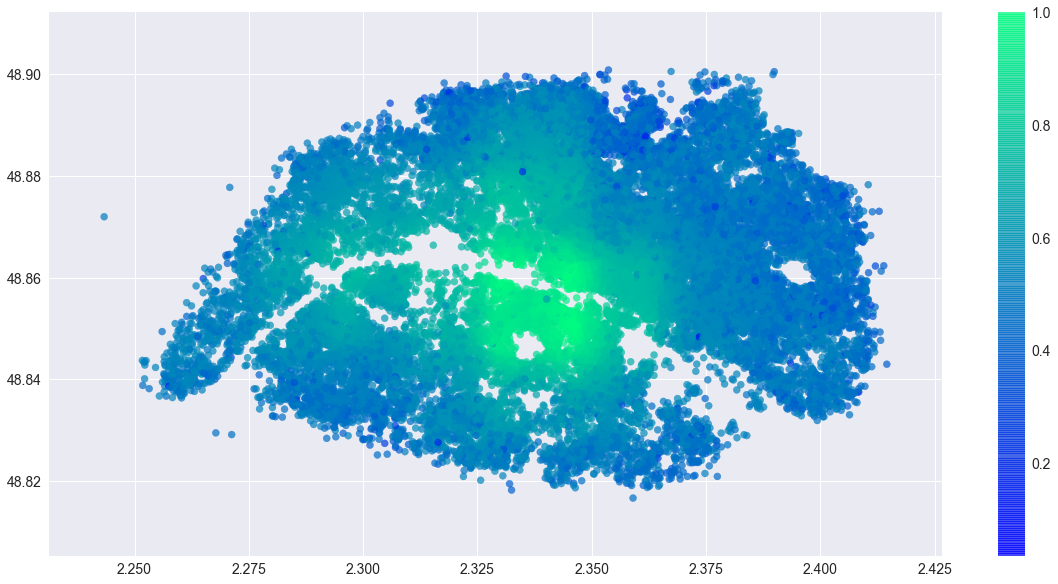

In [10]:
fig = plt.figure(figsize=(20,10))
plt.scatter(mys.longitude.values, mys.latitude.values, s=50, c=mys.total_score.values, cmap='winter' ,zorder=2, alpha=0.7)
plt.colorbar()
plt.show()